<a href="https://colab.research.google.com/github/shy222/DSCI498-Final-Project/blob/main/DSCI498_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Installing necessary libraries
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline
import tensorflow_datasets as tfds

from matplotlib import gridspec


Loaded the "RockPaperScissors" dataset from Tensorflow Datasets

In [3]:
ds = tfds.load('RockPaperScissors', split='train', as_supervised=True, shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompletePO6N42/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompletePO6N42/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


Shuffled the dataset to ensure randomness.

In [4]:
ds = ds.shuffle(1000).batch(128)

Each image has a shape of (300, 300, 3), indicating height, width, and
3 color channels (RGB).

The target variable (label) in each element of the dataset is represented as a tensor with a shape of (None,) and a data type of int64. This means that the target variable is a one-dimensional array (vector) with a variable batch size, where each element corresponds to a specific class or category.

In [5]:
ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

This label_dict dictionary maps the integer labels to their corresponding class names in the dataset.

In [6]:
# Create dictionary of target classes
label_dict = {
 0: 'Rock',
 1: 'Paper',
 2: 'Scissors'
}

Creates a visualization of a batch of images from the dataset along with their corresponding labels

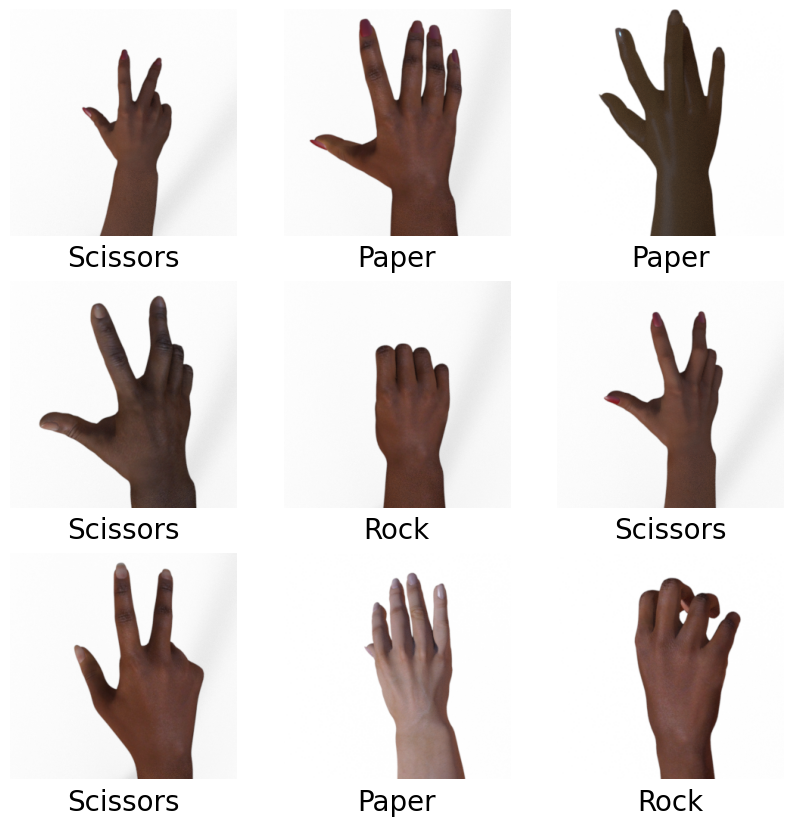

In [7]:
plt.figure(figsize=(10, 10))
for image, label in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        lab = np.array(label[i])
        plt.text(0.5, -0.1, s = label_dict[int(lab)], horizontalalignment='center',
     verticalalignment='center', transform = ax.transAxes, fontsize=20)
        plt.imshow(image[i])
        plt.axis("off")

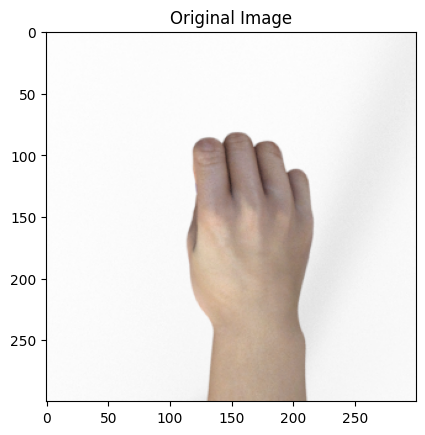

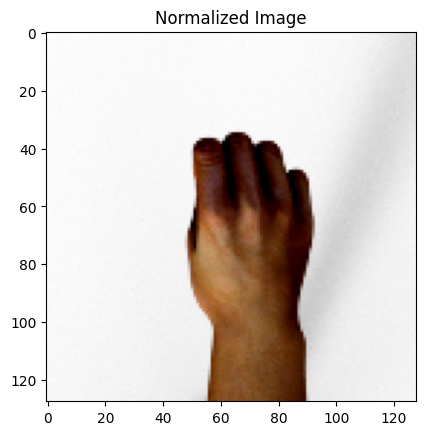

In [8]:

@tf.function
def normalization(tensor):
    tensor = tf.image.resize(tensor, (128,128))
    tensor = tf.subtract(tf.divide(tensor, 127.5), 1)
    return tensor



# Iterate over the dataset and retrieve the first image
for sample_image, _ in ds.take(1):
    # Display the original image
    plt.imshow(sample_image[0])
    plt.title('Original Image')
    plt.show()

    # Normalize the image
    normalized_image = normalization(sample_image)

    # Display the normalized image
    plt.imshow(normalized_image[0])
    plt.title('Normalized Image')
    plt.show()



In [9]:
for img, label in ds.take(1):
    img = tf.cast(img, tf.float32)
    imgs = normalization(img)
    print(imgs.shape)

(128, 128, 128, 3)


In [10]:
BATCH_SIZE=128
latent_dim = 100

In [11]:
# label input
con_label = layers.Input(shape=(1,))

# latent vector input
latent_vector = layers.Input(shape=(latent_dim,))

In [12]:
def label_conditioned_generator(n_classes=3, embedding_dim=100):
    # embedding for categorical input
    label_embedding = layers.Embedding(n_classes, embedding_dim)(con_label)
    # linear multiplication
    nodes = 4 * 4
    label_dense = layers.Dense(nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((4, 4, 1))(label_dense)
    return label_reshape_layer

def latent_input(latent_dim=100):
    # image generator input
    nodes = 512 * 4 * 4
    latent_dense = layers.Dense(nodes)(latent_vector)
    latent_dense = layers.ReLU()(latent_dense)
    latent_reshape = layers.Reshape((4, 4, 512))(latent_dense)
    return latent_reshape

In [13]:
from graphviz import Digraph

def plot_latent_vector_flow():
    dot = Digraph()

    # Add nodes
    dot.node('latent_vector', 'Latent Vector')
    dot.node('dense', 'Dense Layer')
    dot.node('relu', 'ReLU Activation')
    dot.node('reshape', 'Reshape Layer')

    # Add edges
    dot.edge('latent_vector', 'dense')
    dot.edge('dense', 'relu')
    dot.edge('relu', 'reshape')

    # Render and save the diagram
    dot.render('latent_vector_flow', format='png', cleanup=True)

# Plot the flow diagram for latent vector input
plot_latent_vector_flow()

In [14]:
from graphviz import Digraph

def plot_label_conditioned_flow():
    dot = Digraph()

    # Add nodes
    dot.node('conditioned_label', 'Conditioned Label')
    dot.node('embedding', 'Embedding Layer')
    dot.node('dense', 'Dense Layer')
    dot.node('reshape', 'Reshape Layer')

    # Add edges
    dot.edge('conditioned_label', 'embedding')
    dot.edge('embedding', 'dense')
    dot.edge('dense', 'reshape')

    # Render and save the diagram
    dot.render('label_conditioned_flow', format='png', cleanup=True)

# Plot the flow diagram for label conditioned input
plot_label_conditioned_flow()


Define the architecture for the generator model in a conditional
generative adversarial network (CGAN).
Combines label-conditioned and latent vector inputs to generate realistic images.
Utilizes convolutional transpose layers to upsample the input and produce high-resolution images.
Includes batch normalization and ReLU activation for stability and non-linearity.
Outputs images with RGB color channels scaled to the range [-1, 1] using the tanh activation function.
Model is defined using the Keras functional API.


In [15]:
# define the final generator model
def define_generator():
    label_output = label_conditioned_generator()
    latent_vector_output= latent_input()
    # merge label_conditioned_generator and latent_input output
    merge = layers.Concatenate()([latent_vector_output, label_output])

    x = layers.Conv2DTranspose(64 * 8, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(merge)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.ReLU(name='relu_1')(x)

    x = layers.Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.ReLU(name='relu_2')(x)

    x = layers.Conv2DTranspose(64 * 2, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.ReLU(name='relu_3')(x)


    x = layers.Conv2DTranspose(64 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.ReLU(name='relu_4')(x)


    out_layer = layers.Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_6')(x)


   # define model
    model = tf.keras.Model([latent_vector,  con_label], out_layer)
    return model

In [16]:
conditional_gen = define_generator()

In [17]:
conditional_gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 8192)                 827392    ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               300       ['input_1[0][0]']             
                                                                                              

plot_model to visualize the architecture diagram of the generator model.
The resulting diagram will be saved as 'generator_architecture.png'

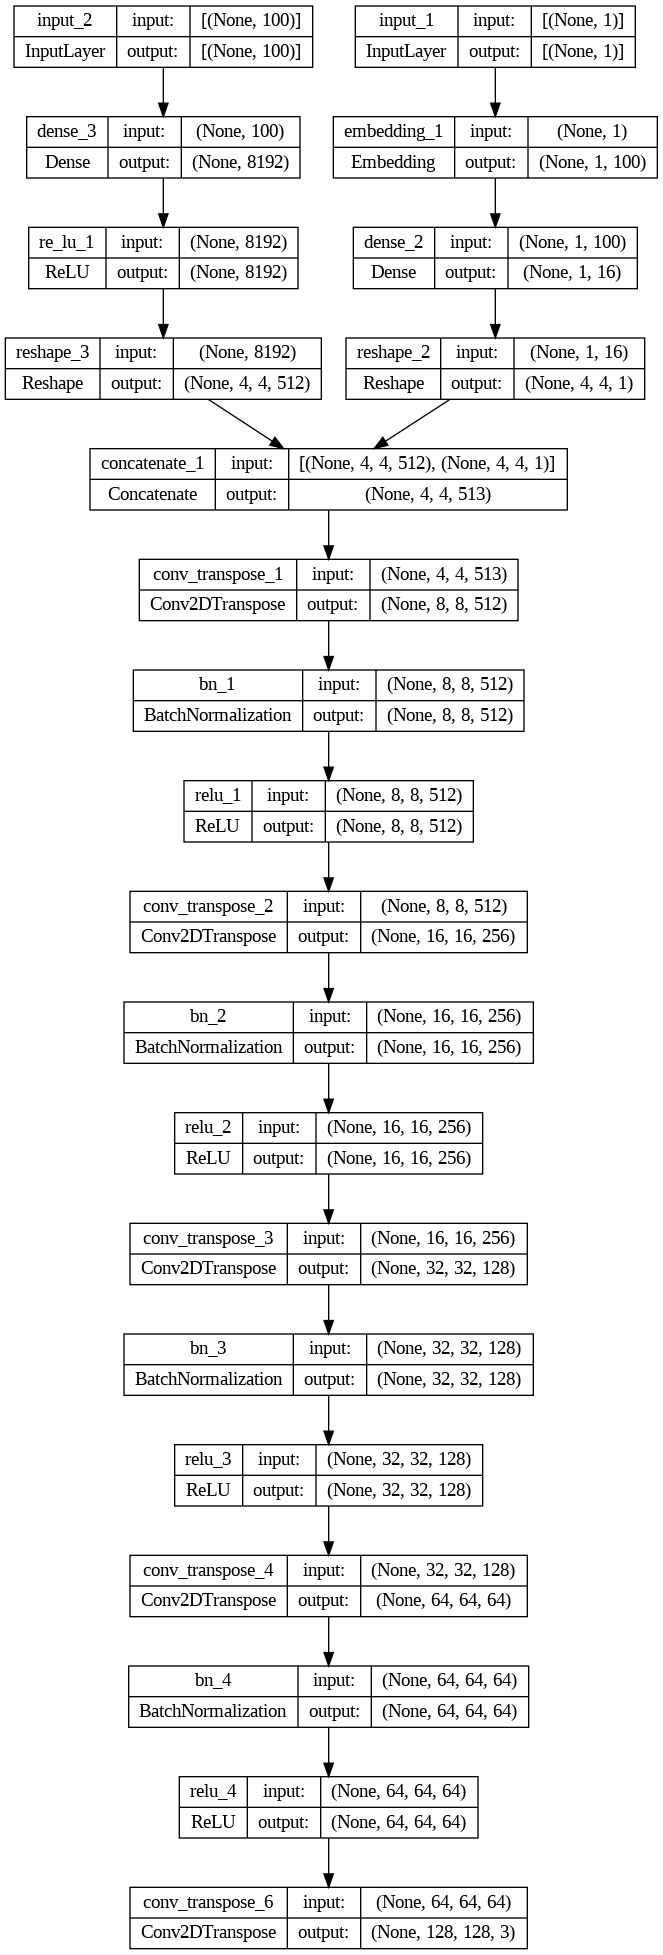

In [18]:
from tensorflow.keras.utils import plot_model

# Define the generator model
generator_model = define_generator()

# Plot the architecture diagram
plot_model(generator_model, to_file='generator_architecture.png', show_shapes=True, show_layer_names=True)


label_condition_disc: Generates an input layer for class labels and transforms them into continuous vectors for the discriminator.

image_disc: Generates an input layer for image data in the discriminator.

In [19]:
def label_condition_disc(in_shape=(128,128,3), n_classes=3, embedding_dim=100):
    # label input
    con_label = layers.Input(shape=(1,))
    # embedding for categorical input
    label_embedding = layers.Embedding(n_classes, embedding_dim)(con_label)
    # scale up to image dimensions with linear activation
    nodes = in_shape[0] * in_shape[1] * in_shape[2]
    label_dense = layers.Dense(nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((in_shape[0], in_shape[1], 3))(label_dense)
    # image input
    return con_label, label_reshape_layer


def image_disc(in_shape=(128,128,3)):
    inp_image = layers.Input(shape=in_shape)
    return inp_image

Constructs a discriminator model for a conditional Generative Adversarial Network (GAN). It concatenates image and label inputs, then processes them through convolutional layers with Leaky ReLU activations and batch normalization. The final output is a binary classification indicating the authenticity of the input images.

In [20]:
def define_discriminator():
    con_label, label_condition_output = label_condition_disc()
    inp_image_output = image_disc()
    # concat label as a channel
    merge = layers.Concatenate()([inp_image_output, label_condition_output])

    x = layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_1')(merge)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)

    x = layers.Conv2D(64 * 2, kernel_size=4, strides= 3, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)

    x = layers.Conv2D(64 * 4, 4, 3, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)

    x = layers.Conv2D(64 * 8, 4, 3,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_5')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_5')(x)


    flattened_out = layers.Flatten()(x)
    # dropout
    dropout = layers.Dropout(0.4)(flattened_out)
    # output
    dense_out = layers.Dense(1, activation='sigmoid')(dropout)
    # define model


    # define model
    model = tf.keras.Model([inp_image_output, con_label], dense_out)
    return model

In [21]:
conditional_discriminator = define_discriminator()

In [22]:
conditional_discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 100)               300       ['input_3[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 1, 49152)             4964352   ['embedding_2[0][0]']         
                                                                                                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                            

Binary cross-entropy loss, which measures the difference between true binary labels and predicted probabilities

In [23]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

This function calculates the generator loss using binary cross-entropy. It compares the discriminator's predictions of fake images with the true labels and computes the loss accordingly.

In [24]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

This function computes the discriminator loss using binary cross-entropy. It calculates the difference between the discriminator's predictions and the true labels, representing the loss incurred during the adversarial training process

In [25]:
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

Initialized Adam optimizers with a learning rate of 0.0002 for both the generator and discriminator models."

In [26]:
learning_rate = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

Generated a random seed of shape (num_examples_to_generate, latent_dim) for visualization of progress over time.

In [28]:
num_examples_to_generate = 25
# We will reuse this seed overtime to visualize progress
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [29]:
seed.dtype

tf.float32

The conditional_discriminator model's input consists of two components: the image input and the label input.

In [30]:
conditional_discriminator.input

[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_3')>]

In [31]:
conditional_gen.input

[<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_1')>]

This code implements a training step for a conditional generative adversarial network (CGAN). It alternates between training the generator to produce realistic images based on specific labels and training the discriminator to distinguish between real and generated images with their associated labels. The training process involves optimizing both the generator and discriminator parameters to improve the quality of generated images over multiple epochs.

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,target):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([target.shape[0], latent_dim])
    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = conditional_gen([noise,target], training=True)
        print(noise.shape)
        print(target.shape)


        real_output = conditional_discriminator([images,target], training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)

    # gradient calculation for discriminator for real labels
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, conditional_discriminator.trainable_variables)

    # parameters optimization for discriminator for real labels
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1,\
    conditional_discriminator.trainable_variables))

    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = conditional_discriminator([generated_images,target], training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
    # gradient calculation for discriminator for fake labels
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, conditional_discriminator.trainable_variables)


    # parameters optimization for discriminator for fake labels
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2,\
    conditional_discriminator.trainable_variables))

    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = conditional_gen([noise,target], training=True)
        fake_output = conditional_discriminator([generated_images,target], training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    # gradient calculation for generator for real labels
    gradients_of_gen = gen_tape.gradient(gen_loss, conditional_gen.trainable_variables)

    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    conditional_gen.trainable_variables))